In [157]:
import numpy as np
import argparse
import time
import os
import sys
import pickle
from itertools import chain
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

from datasets import inputs, sf_inputs_discrete
from sr_model.models.models import AnalyticSR, STDP_SR, OjaRNN, Linear
import configs
from eval import eval

device = 'cpu'

In [750]:
one_hot = False
model = 'sf' # Choices: 'sr', 'oja', 'sf'
gamma = 0.75

In [760]:
num_steps = 2000
num_states = 25
left_right_stay_prob = [4, 1, 1]

if one_hot:
    dset = inputs.Sim1DWalk(
        num_steps=num_steps, left_right_stay_prob=left_right_stay_prob,
        num_states=num_states
        )
else:
    sprs = 0.03
    sig = 2.5
    feature_maker_kwargs = {                                     
        'feature_dim': num_states,
        'feature_type': 'correlated_distributed',
        'feature_vals_p': [1-sprs, sprs], 'feature_vals': None,
        'spatial_sigma': sig
        }
    dset = sf_inputs_discrete.Sim1DWalk(
        num_steps=num_steps, feature_maker_kwargs=feature_maker_kwargs,
        num_states=num_states, left_right_stay_prob=left_right_stay_prob
        )

In [761]:
# Load Model
if model == 'sr':
    save_path = '../trained_models/baseline/'
    model_path = save_path + 'model.pt'
    net_configs_path = save_path + 'net_configs.p'
    with open(net_configs_path, 'rb') as f:
        net_configs = pickle.load(f)
    net_configs.pop('num_states')
    net = STDP_SR(num_states=num_states, **net_configs)
    net.load_state_dict(torch.load(model_path))
elif model == 'oja':
    net = OjaRNN(num_states=num_states, gamma=gamma, ca3_kwargs={'lr':5E-2})
elif model == 'linear':
    net = Linear(input_size=num_states, gamma=gamma, lr=1E-2)
elif model == 'sf':
    ca3_kwargs = {
        'use_dynamic_lr': False, 'parameterize': False,
        'lr': 1E-3
        }
    net = AnalyticSR(
        num_states=num_states, gamma=gamma, ca3_kwargs=ca3_kwargs
        )
elif model == 'sf-parameterized':
    save_path = '/Volumes/aronov-locker/Ching/03_td_discrete_corr/'
    save_path += f'sparsity{sprs}/sigma{sig}/'
    save_path += '0.75/rnn/0/model.pt'
    ca3_kwargs = {
        'use_dynamic_lr': False, 'parameterize': True,
        'output_params':{'num_iterations': 20,'nonlinearity': 'clamp'}
        }
    net = AnalyticSR(
        num_states=num_states, gamma=0.7, ca3_kwargs=ca3_kwargs
        )
    net.load_state_dict(torch.load(save_path))

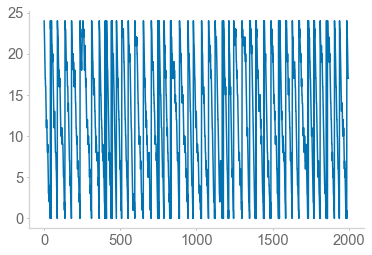

In [762]:
plt.figure()
window = dset.ys[:2000]
plt.plot(np.arange(window.size), window)
plt.show()

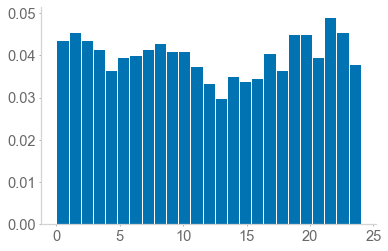

In [763]:
plt.figure()
plt.hist(
    dset.ys, weights=[1/dset.ys.size]*dset.ys.size,
    bins=num_states
    )
plt.show()

# Set up dataset

In [764]:
# Set up dataset
dg_inputs = torch.from_numpy(dset.dg_inputs.T).float().to(device).unsqueeze(1)
dg_modes = torch.from_numpy(dset.dg_modes.T).float().to(device).unsqueeze(1)

# Get development over walk

In [765]:
stop_idxs = np.linspace(0, num_steps, 20, endpoint=True).astype(int)

In [766]:
stop_idxs

array([   0,  105,  210,  315,  421,  526,  631,  736,  842,  947, 1052,
       1157, 1263, 1368, 1473, 1578, 1684, 1789, 1894, 2000])

In [767]:
ff_over_time = [[] for _ in range(num_states)]
for idx in range(stop_idxs.size-1):
    _dg_inputs = dg_inputs[stop_idxs[idx]: stop_idxs[idx+1]]
    if model == 'linear':
        outputs = net(_dg_inputs, reset=idx==0)
        outputs = outputs.squeeze()
    else:
        _, outputs = net(_dg_inputs, dg_modes, reset=idx==0)
        
    ff_M = []
    if model == 'linear':
        outputs = net(dg_inputs, reset=False, update=False)
        outputs = outputs.squeeze()
    else:
        _, outputs = net(dg_inputs, dg_modes, reset=False, update=False)
    for neur in range(num_states):
        ff = []
        for state in range(num_states):
            ff.append(np.mean(
                outputs[dset.ys==state,neur].detach().numpy()
                ))
        ff_over_time[neur].append(ff)

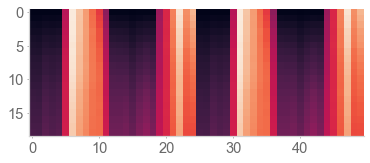

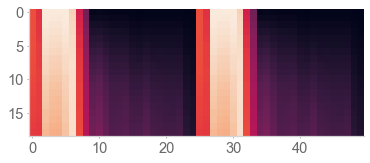

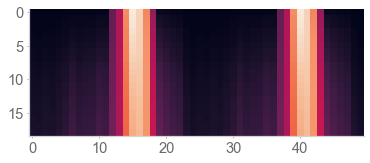

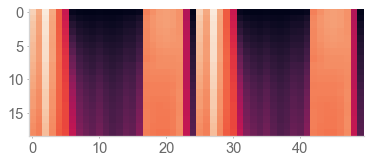

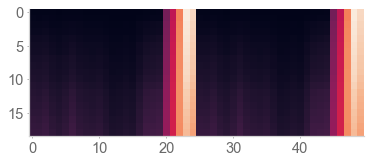

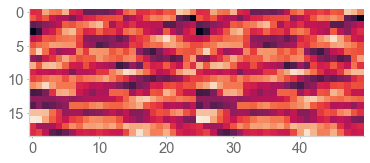

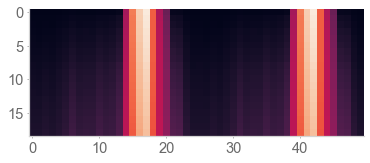

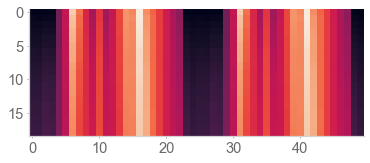

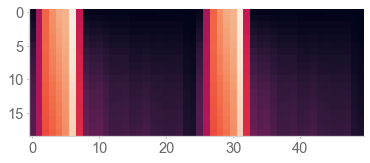

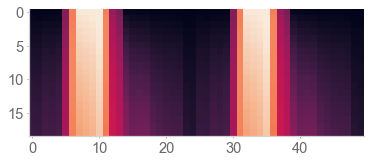

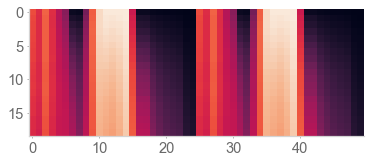

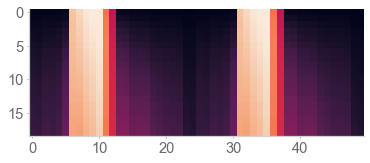

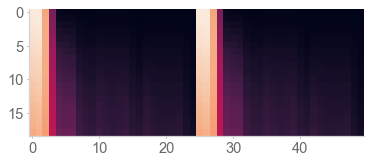

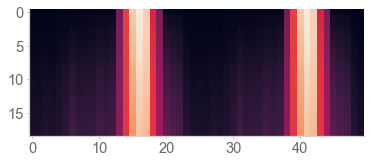

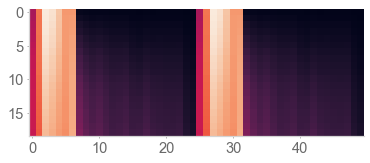

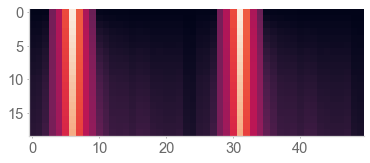

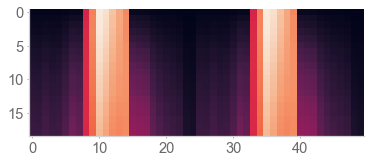

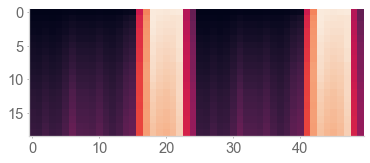

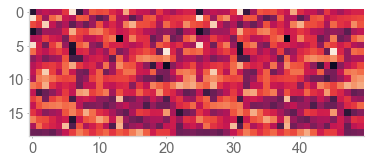

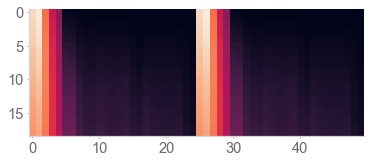

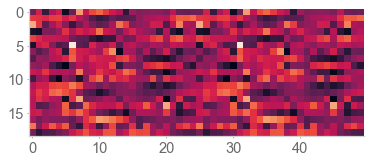

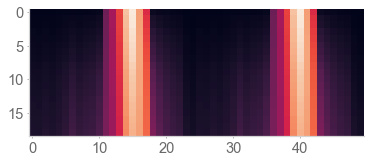

/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_39982/2155282974.py:2: RuntimeWarning: invalid value encountered in true_divide
  ff = [_ff/np.linalg.norm(_ff) for _ff in ff_over_time[neur]]


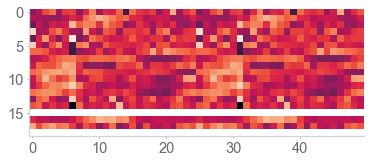

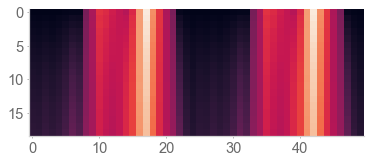

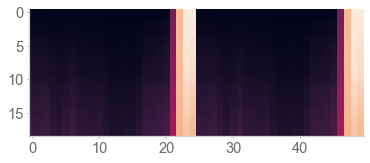

In [768]:
for neur in range(num_states):
    ff = [_ff/np.linalg.norm(_ff) for _ff in ff_over_time[neur]]
    ff = np.array(ff)
    plt.figure()
    plt.imshow(np.tile(ff, (1, 2)))
    plt.show()

# Run first half of the walk

In [738]:
stop_idx = 100

if model == 'linear':
    outputs = net(dg_inputs[:stop_idx], reset=True)
    outputs = outputs.squeeze()
else:
    _, outputs = net(dg_inputs[:stop_idx], dg_modes[:stop_idx], reset=True)

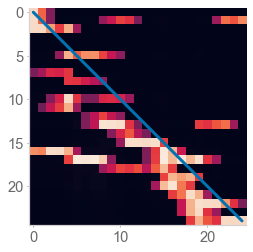

In [739]:
ff_M = []
for neur in range(num_states):
    ff = []
    for state in range(num_states):
        ff.append(np.mean(
            outputs[dset.ys[:stop_idx]==state,neur].detach().numpy()
            ))
    ff_M.append(ff)

plt.figure()
ff_M = np.array(ff_M)
plt.imshow(ff_M[np.argsort(np.argmax(ff_M,axis=1)).astype(int),:])
plt.plot([0,num_states-1], [0,num_states-1], linewidth=3.)
plt.show()

In [740]:
init_argsort = np.argsort(np.argmax(ff_M,axis=1)).astype(int)

In [741]:
init_peaks = np.argmax(ff_M[np.argsort(np.argmax(ff_M,axis=1)).astype(int),:], axis=0)

# Run full walk

In [742]:
if model == 'linear':
    outputs = net(dg_inputs, reset=True)
    outputs = outputs.squeeze()
else:
    _, outputs = net(dg_inputs, dg_modes, reset=True)

In [743]:
if one_hot:
    M = net.get_M(gamma=gamma).detach().numpy().squeeze()

In [744]:
if one_hot:
    for i in range(num_states):
        plt.figure()
        plt.plot(M[i].tolist()*1)
        plt.show()

In [745]:
if one_hot:
    plt.figure()
    plt.imshow(M)
    plt.show()

In [746]:
ff_M = []
if model == 'linear':
    outputs = net(dg_inputs, reset=False, update=False)
    outputs = outputs.squeeze()
else:
    _, outputs = net(dg_inputs, dg_modes, reset=False, update=False)
for neur in range(num_states):
    ff = []
    for state in range(num_states):
        ff.append(np.mean(
            outputs[dset.ys==state,neur].detach().numpy()
            ))
    ff_M.append(ff)

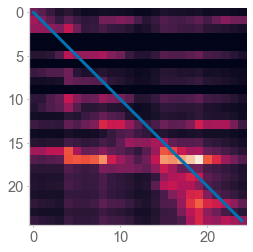

In [747]:
plt.figure()
ff_M = np.array(ff_M)
plt.imshow(ff_M[init_argsort,:])
plt.plot([0,num_states-1], [0,num_states-1], linewidth=3.)
plt.show()

In [748]:
peaks = np.argmax(ff_M[init_argsort,:], axis=0)

In [749]:
peaks - init_peaks

array([14, 14,  0,  0,  6,  0,  0,  0,  4,  4,  0,  0,  0,  0,  2,  0, -3,
        0, -4,  0, -5, -5, -2,  0,  0])

# Prospective Coding Analysis

In [179]:
from sklearn.linear_model import LinearRegression

In [180]:
X = outputs.detach().numpy()[:-1]
y = dset.ys[1:]

In [181]:
X = outputs.detach().numpy()
y = dset.ys

In [182]:
reg = LinearRegression().fit(X, y)

In [183]:
reg.score(X, y)

0.998455115515162